In [1]:
from kan import *
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
torch.set_default_dtype(torch.float64)
dim = 2
np_i = 21 # number of interior points (along each dimension)
np_b = 21 # number of boundary points (along each dimension)
ranges = [-1, 1]
model = KAN(width=[2,2,1], grid=5, k=3, grid_eps=1.0, noise_scale_base=0.25)
def batch_jacobian(func, x, create_graph=False):
    # x in shape (Batch, Length)
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)
# define solution
sol_fun = lambda x: torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]])
source_fun = lambda x: -2*torch.pi**2 * torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]])
# interior
sampling_mode = 'mesh' # 'radnom' or 'mesh'

x_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
y_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")
if sampling_mode == 'mesh':
    #mesh
    x_i = torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
else:
    #random
    x_i = torch.rand((np_i**2,2))*2-1
# boundary, 4 sides
helper = lambda X, Y: torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
xb1 = helper(X[0], Y[0])
xb2 = helper(X[-1], Y[0])
xb3 = helper(X[:,0], Y[:,0])
xb4 = helper(X[:,0], Y[:,-1])
x_b = torch.cat([xb1, xb2, xb3, xb4], dim=0)
steps = 20
alpha = 0.1
log = 1

def train():
    optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    pbar = tqdm(range(steps), desc='description')

    for _ in pbar:
        def closure():
            global pde_loss, bc_loss
            optimizer.zero_grad()
            # interior loss
            sol = sol_fun(x_i)
            sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:,0,:]
            sol_D1 = sol_D1_fun(x_i)
            sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:,:,:]
            lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
            source = source_fun(x_i)
            pde_loss = torch.mean((lap - source)**2)

            # boundary loss
            bc_true = sol_fun(x_b)
            bc_pred = model(x_b)
            bc_loss = torch.mean((bc_pred-bc_true)**2)

            loss = alpha * pde_loss + bc_loss
            loss.backward()
            return loss

        if _ % 5 == 0 and _ < 50:
            model.update_grid_from_samples(x_i)

        optimizer.step(closure)
        sol = sol_fun(x_i)
        loss = alpha * pde_loss + bc_loss
        l2 = torch.mean((model(x_i) - sol)**2)

        if _ % log == 0:
            pbar.set_description("pde loss: %.2e | bc loss: %.2e | l2: %.2e " % (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), l2.detach().numpy()))

train()

pde loss: 2.30e+00 | bc loss: 5.62e-02 | l2: 2.25e-02 : 100%|██████████| 20/20 [00:09<00:00,  2.20it/s]


In [ ]:
def plot_true():
        """ plot the solution on new data """

        import matplotlib.pyplot as plt
        from mpl_toolkits.axes_grid1 import make_axes_locatable

        x = torch.linspace(-1, 1, 200)
        t = torch.linspace(-1, 1, 200)

        # x & t grids:
        X, T = torch.meshgrid(x, t, indexing=None)

        # x & t columns:
        xcol = X.reshape(-1, 1)
        tcol = T.reshape(-1, 1)

        x_i = torch.stack([xcol.reshape(-1,), tcol.reshape(-1,)]).permute(1,0)

        # one large column:
        usol = sol_fun(x_i)

        # reshape solution:
        U = usol.reshape(x.numel(), t.numel())

        # transform to numpy:
        xnp = x.numpy()
        tnp = t.numpy()
        Unp = U.detach().numpy()

        # plot:
        fig = plt.figure(figsize=(9, 4.5))
        ax = fig.add_subplot(111)

        h = ax.imshow(Unp,
                      interpolation='nearest',
                      cmap='rainbow',
                      extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()],
                      origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.10)
        cbar = fig.colorbar(h, cax=cax)
        cbar.ax.tick_params(labelsize=10)
        plt.show()

plot_true()

/Users/lihaoyang/anaconda3/envs/pykan/lib/python3.9/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


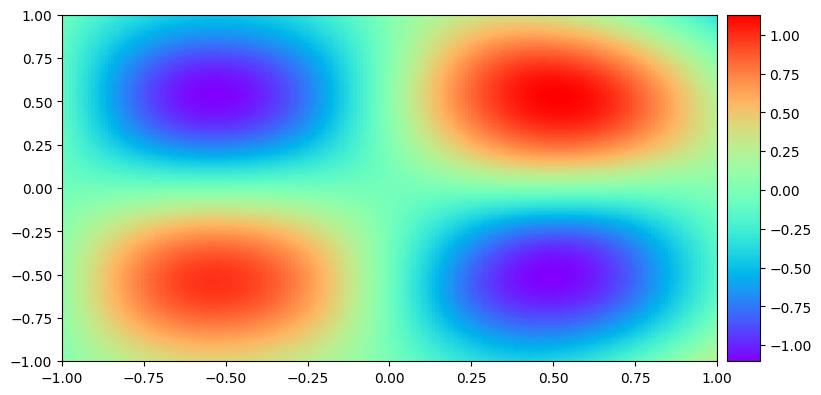

In [2]:
def plot_kan(model):
        """ plot the solution on new data """

        import matplotlib.pyplot as plt
        from mpl_toolkits.axes_grid1 import make_axes_locatable

        x = torch.linspace(-1, 1, 200)
        t = torch.linspace(-1, 1, 200)

        # x & t grids:
        X, T = torch.meshgrid(x, t, indexing=None)

        # x & t columns:
        xcol = X.reshape(-1, 1)
        tcol = T.reshape(-1, 1)

        x_i = torch.stack([xcol.reshape(-1,), tcol.reshape(-1,)]).permute(1,0)

        # one large column:
        kan_sol = model(x_i)

        # reshape solution:
        U = kan_sol.reshape(x.numel(), t.numel())

        # transform to numpy:
        xnp = x.numpy()
        tnp = t.numpy()
        Unp = U.detach().numpy()

        # plot:
        fig = plt.figure(figsize=(9, 4.5))
        ax = fig.add_subplot(111)

        h = ax.imshow(Unp,
                      interpolation='nearest',
                      cmap='rainbow',
                      extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()],
                      origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.10)
        cbar = fig.colorbar(h, cax=cax)
        cbar.ax.tick_params(labelsize=10)
        plt.show()

plot_kan(model)

使用另一种方式求偏微分项

In [3]:
from tkinter.tix import Tree
from kan import *
import torch
from torch import autograd
from tqdm import tqdm
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)

# x=[-1,1] y=[-1,1]
steps = 20
pde_losses = []
bc_losses = []

x = torch.linspace(-1, 1, 21, requires_grad=False)
y = torch.linspace(-1, 1, 21, requires_grad=False)
X, Y = torch.meshgrid(x, y, indexing='ij')
coordinates = torch.stack([X.flatten(), Y.flatten()], dim=1)
coordinates.requires_grad = True  # Ensure coordinates require grad

model = KAN(width=[2,2,1], grid=5, k=3, grid_eps=1.0, noise_scale_base=0.25)

def batch_jacobian(func, x, create_graph=False):
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)

def batch_hessian(func, x):
    jacobian = batch_jacobian(func, x, create_graph=True)
    hessians = []
    for i in range(jacobian.size(1)):
        grad = autograd.grad(jacobian[:, i].sum(), x, create_graph=True, retain_graph=True)[0]
        hessians.append(grad.unsqueeze(1))
    return torch.cat(hessians, dim=1)
# 求导，获取偏微分项
def gradients(u, x, order=1):
    if order == 1:
        return torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                   create_graph=True,
                                   retain_graph=True)[0]
    else:
        return gradients(gradients(u, x), x, order=order - 1)

def burgers_residuals(coords):
    global pde_loss, bc_loss
    coords = coords.clone().detach().requires_grad_(True)  # Ensure coords require grad
    u = model(coords)
    grads = batch_jacobian(model, coords, create_graph=True)
    hessians = batch_hessian(model, coords)

    sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:,0,:]
    sol_D2 = batch_jacobian(sol_D1_fun, coords, create_graph=True)[:,:,:]
    tri=torch.diagonal(sol_D2, dim1=1, dim2=2)
    lap = torch.sum(tri, dim=1, keepdim=True)

    u_xx, u_yy= hessians[:, :, 0], hessians[:, :, 1]

    x=coords[:,0]
    y=coords[:,1]
    xx=gradients(u,x,2)
    yy=gradients(u,y,2)

    out=xx+yy

    pdts=u_xx+u_yy

    residual = out + 2*torch.pi**2 * torch.sin(torch.pi*coords[:,0].reshape(-1,1))*torch.sin(torch.pi*coords[:,1].reshape(-1,1))

    left_mask = (coords[:, 0] == -1)
    right_mask = (coords[:, 0] == 1)
    up_mask = (coords[:, 1] == 1)
    down_mask = (coords[:, 1] == -1)

    left_loss = torch.mean(u[left_mask] ** 2)
    right_loss = torch.mean(u[right_mask] ** 2)
    up_loss = torch.mean(u[up_mask] ** 2)
    down_loss = torch.mean(u[down_mask] ** 2)

    pde_loss = torch.mean(residual ** 2)
    bc_loss = left_loss + up_loss + down_loss + right_loss
    total_loss = pde_loss + bc_loss
    
    return total_loss

def train():
    # optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
    optimizer=torch.optim.LBFGS(model.parameters(),lr=1,line_search_fn="strong_wolfe")
    
    pbar = tqdm(range(steps), desc='Training Progress')

    for step in pbar:
        def closure():
            optimizer.zero_grad()
            loss = burgers_residuals(coordinates)
            loss.backward()
            return loss

        optimizer.step(closure)
        if step % 1 == 0:
            current_loss = closure()
            pbar.set_description("pde loss: %.2e | bc loss: %.2e | total loss: %.2e " % (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), current_loss.detach().numpy()))

        if step % 5 == 0 and step < 50:
            model.update_grid_from_samples(coordinates)
            
        pde_losses.append(pde_loss.detach().numpy())
        bc_losses.append(bc_loss.detach().numpy())

        plt.plot(pde_losses, marker='o')
        plt.plot(bc_losses, marker='o')
        plt.yscale('log')
        plt.xlabel('steps')
        plt.legend(['PDE loss', 'BC loss'])

train()

Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

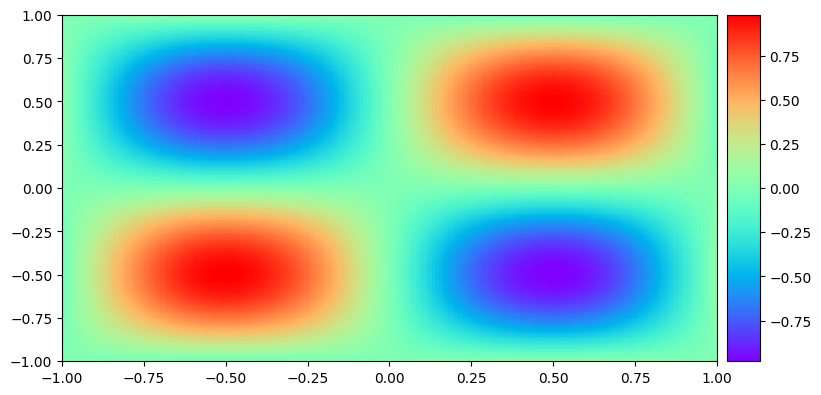

In [5]:
def plot_kan(model):
        """ plot the solution on new data """

        import matplotlib.pyplot as plt
        from mpl_toolkits.axes_grid1 import make_axes_locatable

        x = torch.linspace(-1, 1, 200)
        t = torch.linspace(-1, 1, 200)

        # x & t grids:
        X, T = torch.meshgrid(x, t, indexing=None)

        # x & t columns:
        xcol = X.reshape(-1, 1)
        tcol = T.reshape(-1, 1)

        x_i = torch.stack([xcol.reshape(-1,), tcol.reshape(-1,)]).permute(1,0)

        # one large column:
        kan_sol = model(x_i)

        # reshape solution:
        U = kan_sol.reshape(x.numel(), t.numel())

        # transform to numpy:
        xnp = x.numpy()
        tnp = t.numpy()
        Unp = U.detach().numpy()

        # plot:
        fig = plt.figure(figsize=(9, 4.5))
        ax = fig.add_subplot(111)

        h = ax.imshow(Unp,
                      interpolation='nearest',
                      cmap='rainbow',
                      extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()],
                      origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.10)
        cbar = fig.colorbar(h, cax=cax)
        cbar.ax.tick_params(labelsize=10)
        plt.show()

plot_kan(model)